In [143]:
import matplotlib.pyplot as plt
import numpy as np
from brainweb_dl import get_mri
import scipy
import pylops
import pyproximal
plt.rcParams["image.cmap"] = "gray"


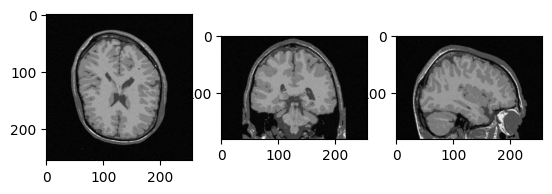

In [144]:
mri_data = get_mri(sub_id=43, contrast="T1")
mri_data = mri_data[::-1, ...]
fig, ax = plt.subplots(1, 3)
ax[0].imshow(mri_data[90, :, :])
ax[1].imshow(mri_data[:, 108, :])
ax[2].imshow(mri_data[:, :, 90])

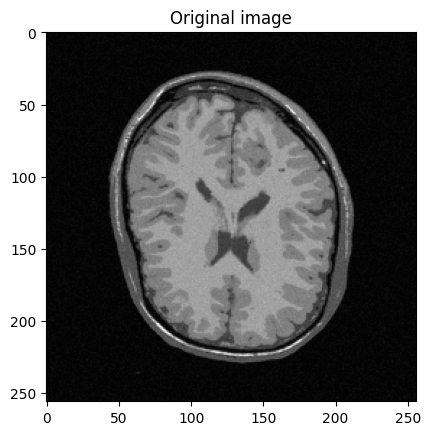

In [145]:
original_img = mri_data[90, :, :]
plt.figure()
plt.imshow(original_img)
plt.title("Original image")
plt.show()


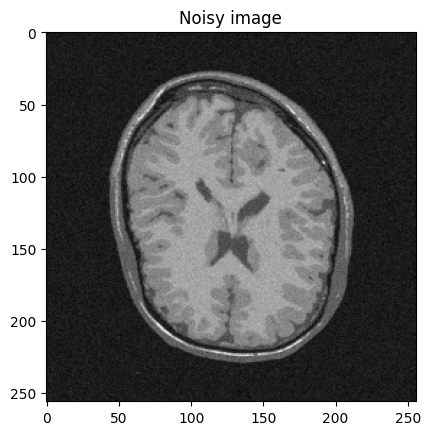

In [146]:
# adding a gaussian noise
np.random.seed(0)
noise = np.random.normal(0, 100, original_img.shape)
noisy_img = original_img + noise
plt.figure()
plt.imshow(noisy_img)
plt.title("Noisy image")
plt.show()

img = noisy_img


In [147]:
# print img size
print("Image size: ", img.shape)

Image size:  (256, 256)


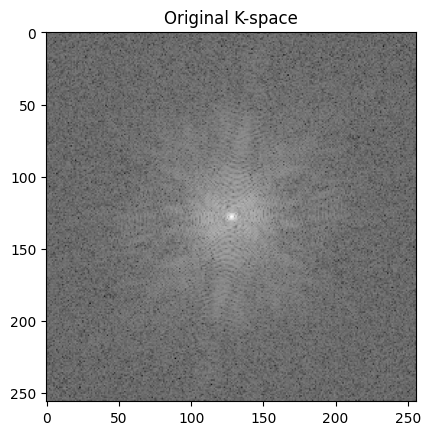

In [148]:
# transform the image into kspace

from scipy.fftpack import fftn

kspace = fftn(img)
kspace = np.fft.fftshift(kspace)

plt.figure()
plt.title("Original K-space")
plt.imshow(np.log(np.abs(kspace)+1))
plt.show()


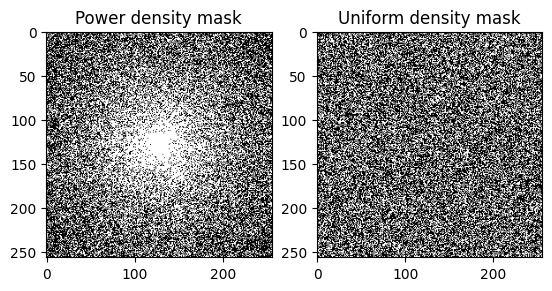

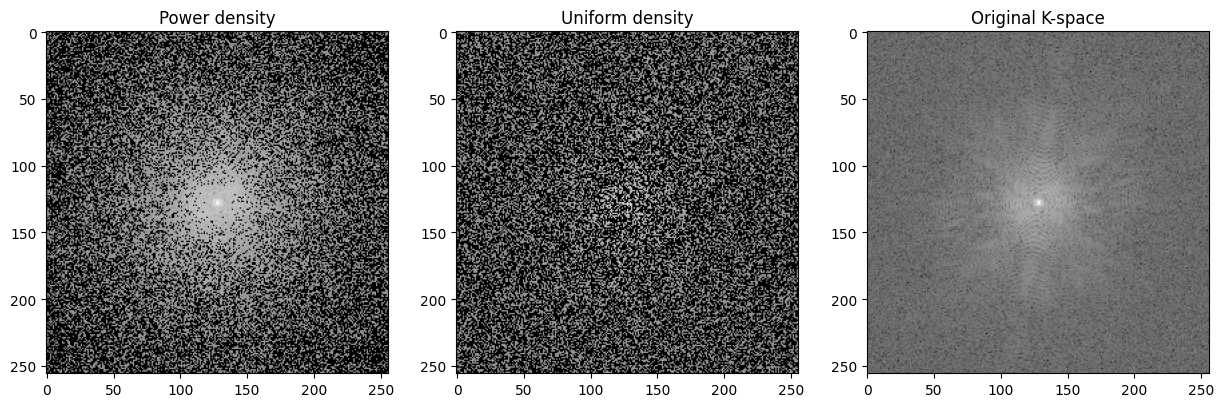

In [150]:
# Create a mask with a power distribution

power_density_mask = np.zeros_like(kspace, dtype=float)
center_x, center_y = power_density_mask.shape[0] // 2, power_density_mask.shape[1] // 2
max_radius = np.sqrt(center_x ** 2 + center_y ** 2)
for i in range(power_density_mask.shape[0]):
    for j in range(power_density_mask.shape[1]):
        radius = np.sqrt((i - center_x) ** 2 + (j - center_y) ** 2) / max_radius
        # give a 1 or 0 with probability 3*(1 + radius)^2
        power_density_mask[i, j] = np.random.rand() < (1.1 / ((1 + radius) ** (2)))

# create a mask with a unifrom distribution
uniform_density_mask = np.zeros_like(kspace, dtype=float)
for i in range(uniform_density_mask.shape[0]):
    for j in range(uniform_density_mask.shape[1]):
        uniform_density_mask[i, j] = np.random.rand() < 0.40

# plot the masks
plt.figure()
plt.subplot(121)
plt.title("Power density mask")
plt.imshow(power_density_mask)
plt.subplot(122)
plt.title("Uniform density mask")
plt.imshow(uniform_density_mask)
plt.show()


# Apply the masks to the kspace
kspace_undersampled_power = kspace * power_density_mask
kspace_undersampled_uniform = kspace * uniform_density_mask


# Plot the undersampled kspace with power density, uniform density and the original kspace
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Power density")
plt.imshow(np.log(np.abs(kspace_undersampled_power)+1))
plt.subplot(132)
plt.title("Uniform density")
plt.imshow(np.log(np.abs(kspace_undersampled_uniform)+1))
plt.subplot(133)
plt.title("Original K-space")
plt.imshow(np.log(np.abs(kspace)+1))
plt.show()


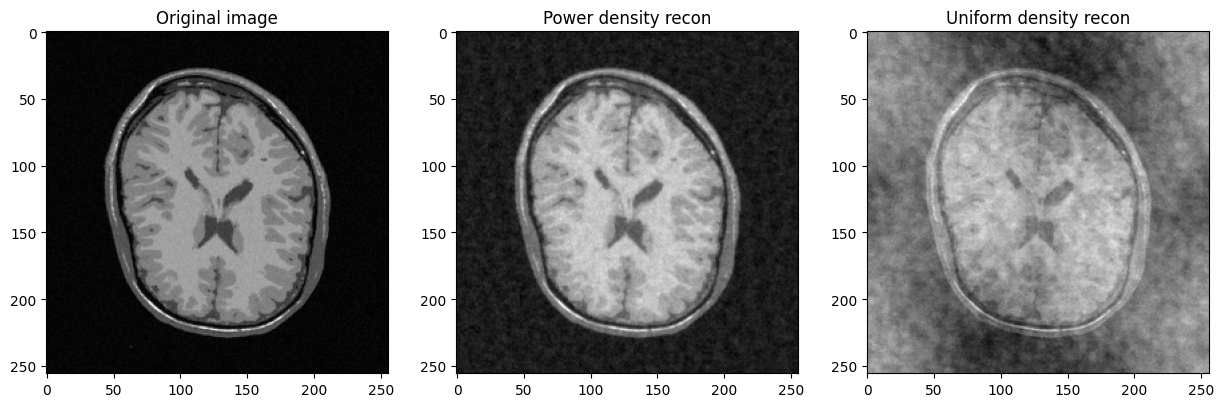

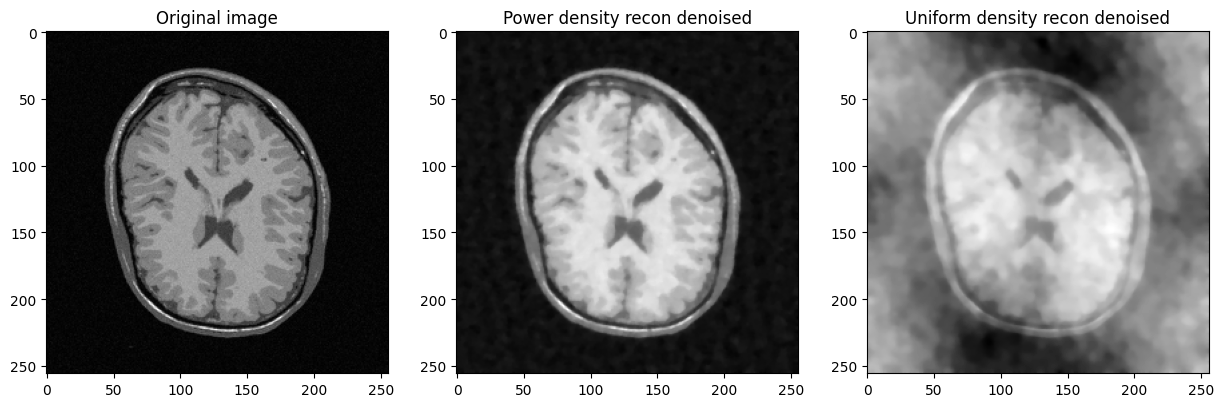

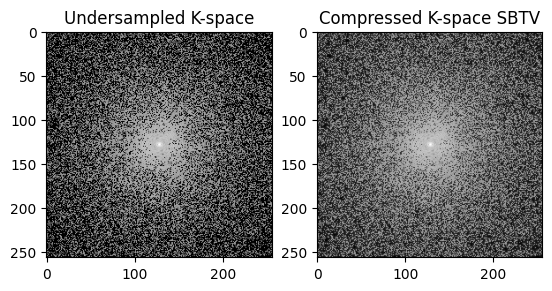

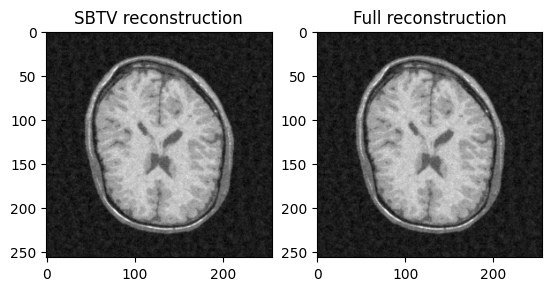

SSIM SBTV:  0.6838811330342351
SSIM Full:  0.6844205930064508
MSE SBTV:  14189.324707743755
MSE Full:  14175.129840787873


In [151]:
from skimage.restoration import denoise_tv_bregman

recon_power = np.fft.ifftn(np.fft.ifftshift(kspace_undersampled_power)).real
recon_uniform = np.fft.ifftn(np.fft.ifftshift(kspace_undersampled_uniform)).real

# plot the image and the recons
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Original image")
plt.subplot(1, 3, 2)
plt.imshow(recon_power)
plt.title("Power density recon")
plt.subplot(1, 3, 3)
plt.imshow(recon_uniform)
plt.title("Uniform density recon")
plt.show()


# deblurring the recons with denoise_tv_bregman
recon_power_denoise = denoise_tv_bregman(recon_power, weight=0.005)
recon_uniform_denoise = denoise_tv_bregman(recon_uniform, weight=0.001)

# plot the denoised images and the original image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Original image")
plt.subplot(1, 3, 2)
plt.imshow(recon_power_denoise)
plt.title("Power density recon denoised")
plt.subplot(1, 3, 3)
plt.imshow(recon_uniform_denoise)
plt.title("Uniform density recon denoised")
plt.show()



# do the compress sensing

kspace_sbtv_real = denoise_tv_bregman(kspace_undersampled_power.real, weight=5)
kspace_sbtv_imaginary = denoise_tv_bregman(kspace_undersampled_power.imag, weight=5)
kspace_sbtv = kspace_sbtv_real + 1j * kspace_sbtv_imaginary


plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(kspace_undersampled_power+1)))
plt.title("Undersampled K-space")
plt.subplot(1, 2, 2)
plt.imshow(np.log(np.abs(kspace_sbtv)+1))
plt.title("Compressed K-space SBTV")
plt.show()

# reconstuct the image with sbtv or not and compare the results

img_sbtv = np.fft.ifftn(np.fft.ifftshift(kspace_sbtv)).real
img_full = np.fft.ifftn(np.fft.ifftshift(kspace_undersampled_power)).real

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img_sbtv)
plt.title("SBTV reconstruction")
plt.subplot(1, 2, 2)
plt.imshow(img_full)
plt.title("Full reconstruction")
plt.show()


# compare the results with the original_image with the SSIM and plot the RMSD of the images

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

ssim_sbtv = ssim(original_img, img_sbtv, data_range=img_sbtv.max() - img_sbtv.min())
ssim_full = ssim(original_img, img_full, data_range=img_full.max() - img_full.min())
print("SSIM SBTV: ", ssim_sbtv, )
print("SSIM Full: ", ssim_full)

mse_sbtv = mse(original_img, img_sbtv)
mse_full = mse(original_img, img_full)
print("MSE SBTV: ", mse_sbtv)
print("MSE Full: ", mse_full)


In [152]:
mat1 = kspace_undersampled_power
sampling1 = power_density_mask
gt = img
Fop = pylops.signalprocessing.FFT2D(dims=gt.shape)
Rop = pylops.Restriction(gt.size, np.where(sampling1.ravel() == 1)[0],
                         dtype=np.complex128)
Dop = Rop * Fop
# Data (Masked KK spectrum)
d = Dop * gt.ravel()
shape = kspace.shape
size = np.prod(shape)


Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.linearoperator._ScaledLinearOperator'>
Additional vector (z): None
tau = 8.396893026590252		mu = 8.750446417183525
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.38015e+01   9.941e+07   3.584e+05   0.000e+00       9.977e+07
     2   1.52394e+01   1.134e+06   3.961e+05   0.000e+00       1.531e+06
     3   1.45720e+01   1.478e+04   3.997e+05   0.000e+00       4.145e+05
     4   1.44708e+01   1.319e+03   3.998e+05   0.000e+00       4.011e+05
     5   1.46036e+01   9.382e+02   3.994e+05   0.000e+00       4.004e+05
     6   1.49302e+01   9.291e+02   3.990e+05   0.000e+00       4.000e+05
     7   1.47976e+01   1.022e+03   3.987e+05   0.000e+00       3.997e+05
     8   1.44440e

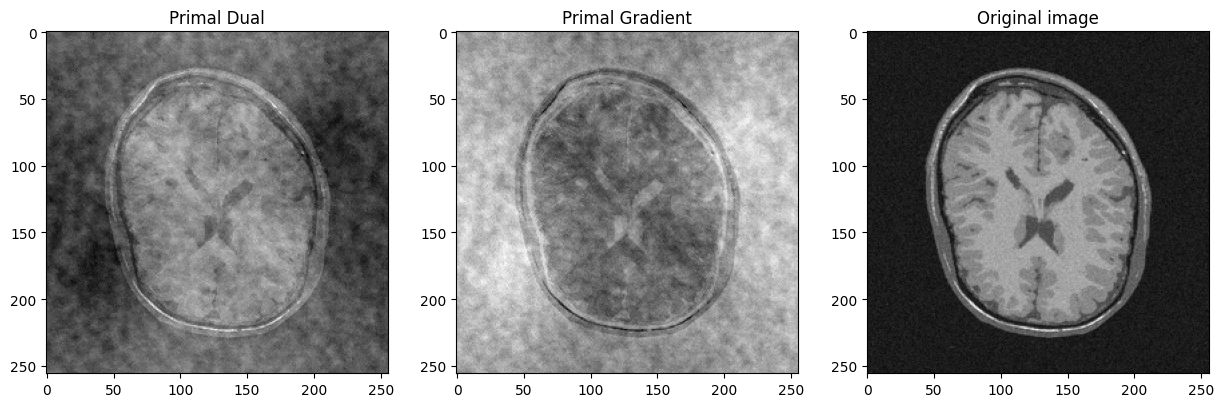

In [142]:
# ISTA
with pylops.disabled_ndarray_multiplication():
    sigma = 0.04
    l1 = pyproximal.proximal.L21(ndim=2)
    l2 = pyproximal.proximal.L2(Op=Dop, b=d.ravel(), niter=100, warm=True)

    Gop = sigma * pylops.Gradient(dims=gt.shape, edge=True, kind='forward', dtype=np.complex128)

    L = sigma ** 2 * 8
    tau = .95 / np.sqrt(L)
    mu = .99 / np.sqrt(L)


    gtpd = \
        pyproximal.optimization.primaldual.PrimalDual(l2, l1, Gop, x0=np.zeros(gt.size), tau=tau,
                                                      mu=mu, theta=1, niter=100, show=True)

    gtpd2 = \
         pyproximal.optimization.primal.ProximalGradient(l2, l1, tau=tau, x0=np.zeros(gt.size),
                                                         epsg=1, niter=100, acceleration='fista', show=True)
    #gtpd = np.real(gtpd.reshape(gt.shape))

    gtpd = np.real(gtpd.reshape(gt.shape))

    gtpd2 = np.real(gtpd2.reshape(gt.shape))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(gtpd)
plt.title("Primal Dual")
plt.subplot(1, 3, 2)
plt.imshow(gtpd2)
plt.title("Primal Gradient")
plt.subplot(1, 3, 3)
plt.imshow(img)
plt.title("Original image")
plt.show()


In [11]:
# compute the purcentage of zero coefficient in random + compressed sensing and random and ista

print("Percentage of zero coefficients in random undersampling + compressed sensing: {:.2f}%".format(
    np.sum(kspace_sbtv == 0) / kspace_sbtv.size * 100))
print("Percentage of zero coefficients in random undersampling: {:.2f}%".format(
    np.sum(kspace_undersampled_power == 0) / kspace_undersampled_power.size * 100))
print("Percentage of zero coefficients in random undersampling + ISTA: {:.2f}%".format(
    np.sum(kspace_ista == 0) / kspace_ista.size * 100))


Percentage of zero coefficients in random undersampling + compressed sensing: 0.00%
Percentage of zero coefficients in random undersampling: 84.51%
Percentage of zero coefficients in random undersampling + ISTA: 0.00%


In [19]:
import mrinufft
from mrinufft.density import voronoi
NufftOperator = mrinufft.get_operator("finufft")

samples_loc = []
for i in range(len(mask_power_distribution)):
    for j in range(len(mask_power_distribution[0])):
        if mask_power_distribution[i, j] == 1:
            samples_loc.append([i, j])

samples_loc = np.array(samples_loc).astype(float)
samples_loc[:, 0] = samples_loc[:, 0] - samples_loc[:, 0].mean()
samples_loc[:, 1] = samples_loc[:, 1] - samples_loc[:, 1].mean()
samples_loc = samples_loc / samples_loc.max()

density = voronoi(samples_loc)
nufft = NufftOperator(
    samples_loc, shape=img.shape, density=density, n_coils=1, squeeze_dims=True
)

undersampled_kspace = nufft.op(img)  # Image -> Kspace
print(undersampled_kspace.shape)

from skimage.restoration import denoise_tv_bregman

kspace_sbtv_real = denoise_tv_bregman(undersampled_kspace.real, weight=5)
kspace_sbtv_imaginary = denoise_tv_bregman(undersampled_kspace.imag, weight=5)
undersampled_kspace_sbtv = kspace_sbtv_real + 1j * kspace_sbtv_imaginary


image1 = nufft.adj_op(undersampled_kspace)  # Kspace -> Image
print(image1.shape)
image2 = nufft.adj_op(undersampled_kspace_sbtv)  # Kspace -> Image


/Users/christophermarouani/.local/lib/python3.12/site-packages/mrinufft/_utils.py:92: UserWarning: Samples will be rescaled to [-0.5, 0.5), assuming they were in [-pi, pi)
  warnings.warn(


(10149,)
(256, 256)


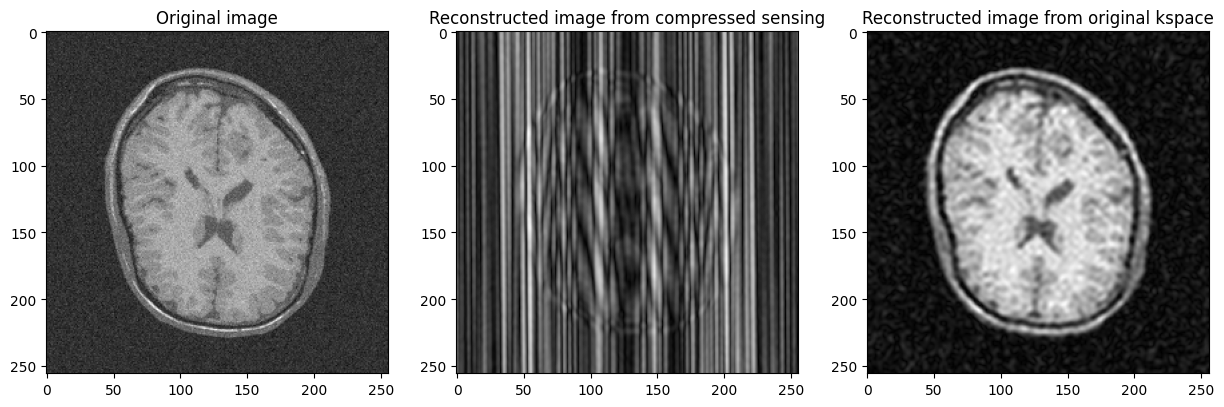

In [17]:

# plot the original image and the reconstructed images from the kspace
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original image")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(image2))
plt.title("Reconstructed image from compressed sensing")
plt.subplot(1, 3, 3)
plt.imshow(np.abs(image1))
plt.title("Reconstructed image from original kspace")
plt.show()
